# Extended Research Project Model Development (rf)

## 1. Preprocess the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 6.4 MB/s eta 0:00:00


In [3]:
# === Step 0: Import Libraries ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import optuna
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [4]:
# === Step 1: Data Preparation ===
# load the data
df = pd.read_csv("/content/drive/MyDrive/ERP/Random Forest/Final_xgb_rf.csv.gz", compression="gzip")

df

,net_income_usd,total_assets_usd,shareholders_funds_usd,capital_usd,revenue_usd,schooling_years_2020,urban_pop_growth_2022,logistics_index_2018,life_expectancy_2022,female_labor_participation_2023,...,accounting_template,dm_gender,wb_category,accounting_template_missing,website_exists,description_exists,duo_bvd_id_exists,dm_gender_missing,capital_usd_missing,shareholders_funds_usd_missing
0,9.447491e+05,1.019737e+07,1.501043e+06,0.000000,3.541786e+06,10.680542,38.765999,3.273980,74.580,69.533,...,0,2,0,1,0,1,0,1,0,0
1,1.765783e+04,3.462970e+05,3.748563e+04,31153.103599,1.437969e+06,10.680542,38.765999,3.273980,74.580,69.533,...,0,2,0,1,0,1,0,1,0,0
2,-2.502728e+04,5.999055e+05,-7.393448e+04,8380.122017,1.246335e+06,10.680542,38.765999,3.273980,74.580,69.533,...,0,2,0,1,1,1,1,1,0,0
3,1.023630e+03,3.339065e+05,7.992075e+03,4190.061009,7.675140e+05,10.680542,38.765999,3.273980,74.580,69.533,...,0,2,0,1,0,1,0,1,0,0
4,6.034728e+02,3.309006e+05,5.263626e+03,4190.061009,7.037159e+05,10.680542,38.765999,3.273980,74.580,69.533,...,0,2,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477072,-9.593861e+03,6.979673e+04,6.870639e+04,85284.154826,-7.980458e+03,7.872839,87.555000,2.985790,73.425,53.205,...,0,1,1,0,0,0,0,0,0,0
477073,-1.343988e+04,4.042509e-01,-1.914622e+03,7461.924866,-1.343954e+04,7.872839,87.555000,2.985790,73.425,53.205,...,0,1,1,0,0,0,1,0,0,0
477074,-1.027999e+05,1.687618e+05,4.746779e+04,16133.758016,-9.145863e+04,9.270027,63.560001,3.605147,78.587,59.948,...,0,1,1,0,0,0,0,0,1,0
477075,-7.534849e+01,4.646490e+02,-1.208715e+02,499.056965,-9.680114e+05,9.270027,63.560001,3.605147,78.587,59.948,...,0,1,1,0,0,0,0,0,1,0


In [5]:
# create a df for classification
df_cls = df.copy()

# drop NaN
df_cls = df_cls.dropna()
df_cls.isna().sum().sum()

np.int64(0)

In [6]:
def create_success_flag(df):
    """
    Create a binary 'success' column based on revenue, net income, and cash flow thresholds.
    A company is considered successful if:
        - revenue_usd > 455.230 (top quartile)
        - net_income_usd > 0 (profitable)

    Parameters:
        df (pd.DataFrame): Input DataFrame containing startup financial data.

    Returns:
        df_new (pd.DataFrame): DataFrame with the added 'success' column.
        success_counts (pd.Series): Count of 0s and 1s in the 'success' column.
    """

    # Make a copy of the original DataFrame to preserve the input
    df_new = df.copy()

    # Define the success condition as a binary indicator
    # This checks whether all three conditions are met for each row
    df_new["success"] = (
        (df_new["revenue_usd"] > 455.230) &      # Top quartile of revenue
        (df_new["net_income_usd"] > 0)           # Positive net income
    ).astype(int)  # Convert boolean values to 0 or 1

    # Drop the columns used for creating the target to avoid data leakage
    df_new.drop(columns=["revenue_usd", "net_income_usd"], inplace=True)

    # Count how many startups are labeled as success (1) and not success (0)
    success_counts = df_new["success"].value_counts().sort_index()

    return df_new, success_counts

In [7]:
# create a df for classification
df_class, success_counts = create_success_flag(df_cls)
print(df_class["success"])
print(success_counts)

0         1
1         1
2         0
3         1
4         1
         ..
477072    0
477073    0
477074    0
477075    0
477076    0
Name: success, Length: 477077, dtype: int64
success
0    390322
1     86755
Name: count, dtype: int64


In [8]:
# CLASSIFICATION: Define target and feature columns
target_col_cls = "success"
feature_cols_cls = [col for col in df_class.columns if col != target_col_cls]

# Extract features and target
X_cls = df_class[feature_cols_cls].values
y_cls = df_class[target_col_cls].values

# Split into train, validation, and test sets (2D arrays only, no reshape)
X_train_cls, X_temp_cls, y_train_cls, y_temp_cls = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42)
X_val_cls, X_test_cls, y_val_cls, y_test_cls = train_test_split(X_temp_cls, y_temp_cls, test_size=0.5, random_state=42)

## 2. Define the rf model

In [9]:
'''
# === Step 2: Define rf Model for classification===
# CLASSIFICATION: Define rf model for Classification
class rfClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(rfClassifier, self).__init__()
        self.rf = nn.rf(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.rf(x)             # rf output
        out = out[:, -1, :]               # Use only last time step
        out = self.fc(out)                # Final classification layer
        return out
'''

'\n# === Step 2: Define rf Model for classification===\n# CLASSIFICATION: Define rf model for Classification\nclass rfClassifier(nn.Module):\n    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):\n        super(rfClassifier, self).__init__()\n        self.rf = nn.rf(input_size, hidden_size, num_layers,\n                            batch_first=True, dropout=dropout)\n        self.fc = nn.Linear(hidden_size, num_classes)\n\n    def forward(self, x):\n        out, _ = self.rf(x)             # rf output\n        out = out[:, -1, :]               # Use only last time step\n        out = self.fc(out)                # Final classification layer\n        return out\n'

## 3. Tune hyperparameters by Optuna

In [10]:
# === Step 3: Optuna Hyperparameter Tuning for rf Classification ===
def objective_rf_cls(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Define and train the model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_cls, y_train_cls)

    # Predict on validation set
    y_pred = model.predict(X_val_cls)

    # Evaluate using weighted F1 score (maximize -> minimize 1 - score)
    return 1 - f1_score(y_val_cls, y_pred, average="weighted")

# Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective_rf_cls, n_trials=30)

# Output best hyperparameters
best_params_cls = study.best_trial.params
print("Best hyperparameters:", best_params_cls)

[I 2025-07-26 14:54:50,805] A new study created in memory with name: no-name-156c6892-cf09-4190-9880-850568f97274
[I 2025-07-26 14:55:16,942] Trial 0 finished with value: 0.13529612282339465 and parameters: {'n_estimators': 234, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.13529612282339465.
[I 2025-07-26 14:56:50,394] Trial 1 finished with value: 0.1289282389278893 and parameters: {'n_estimators': 197, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.1289282389278893.
[I 2025-07-26 14:58:09,346] Trial 2 finished with value: 0.13015821710784714 and parameters: {'n_estimators': 161, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 1 with value: 0.1289282389278893.
[I 2025-07-26 14:58:38,543] Trial 3 finished with value: 0.13112898441940124 and parameters: {'n_estimators': 292, 'max_depth': 20, 'm

Best hyperparameters: {'n_estimators': 83, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None}


## 4. Re-learn with the optimized parameters

In [11]:
# === Step 4: Train Final Model with Best Params (Classification) ===
rf_model_cls = RandomForestClassifier(
    n_estimators=best_params_cls['n_estimators'],
    max_depth=best_params_cls['max_depth'],
    min_samples_split=best_params_cls['min_samples_split'],
    min_samples_leaf=best_params_cls['min_samples_leaf'],
    max_features=best_params_cls['max_features'],
    random_state=42,
    n_jobs=-1
)

# Train the model on the training set
rf_model_cls.fit(X_train_cls, y_train_cls)

# Predict class probabilities
y_proba_val = rf_model_cls.predict_proba(X_val_cls)

# Extract probabilities for each class
prob_0 = y_proba_val[:, 0]  # Probability that class = 0
prob_1 = y_proba_val[:, 1]  # Probability that class = 1

  0%|          | 0/50 [00:00<?, ?it/s]

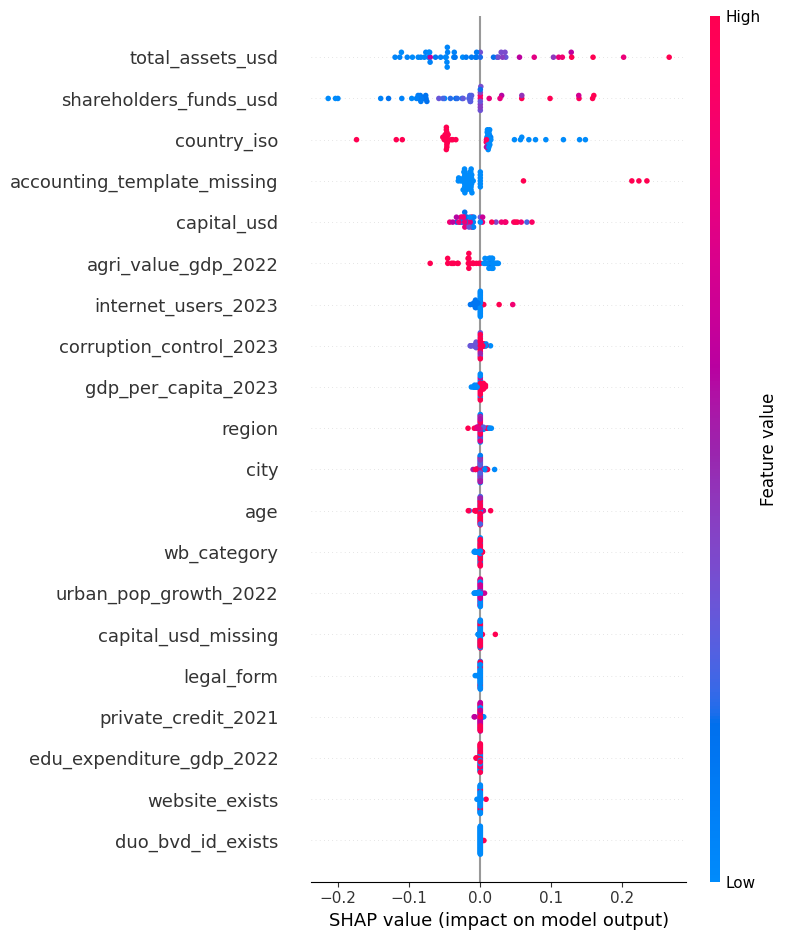

In [12]:
import shap

# === Flatten input data if needed ===
X_train_flat = X_train_cls.reshape(X_train_cls.shape[0], -1)  # Shape: (samples, features)
X_val_flat = X_val_cls.reshape(X_val_cls.shape[0], -1)

# === Define prediction function for rf classifier ===
def model_predict_rf_classifier(X_numpy):
    # Return predicted probabilities for class 1
    return rf_model_cls.predict_proba(X_numpy)[:, 1]  # Shape: (N,)

# === Select background and explanation data ===
background_data = X_train_flat[:100]       # Use a small representative sample
explanation_data = X_val_flat[:50]         # Data to explain

# === Initialize SHAP KernelExplainer ===
explainer = shap.KernelExplainer(model_predict_rf_classifier, background_data)

# === Compute SHAP values (for classification, returns list per class) ===
shap_values = explainer.shap_values(explanation_data)  # shap_values[1] = class 1 (positive class)

# === Convert SHAP values for class 1 to DataFrame and save ===
feature_names = feature_cols_cls if 'feature_cols_cls' in locals() else [f"f{i}" for i in range(X_train_flat.shape[1])]
shap_df = pd.DataFrame(shap_values, columns=feature_cols_cls)
shap_df.to_csv("shap_values_rf_cls.csv", index=False)

# === Generate SHAP summary plot for class 1 ===
shap.summary_plot(shap_values, explanation_data, feature_names=feature_names)

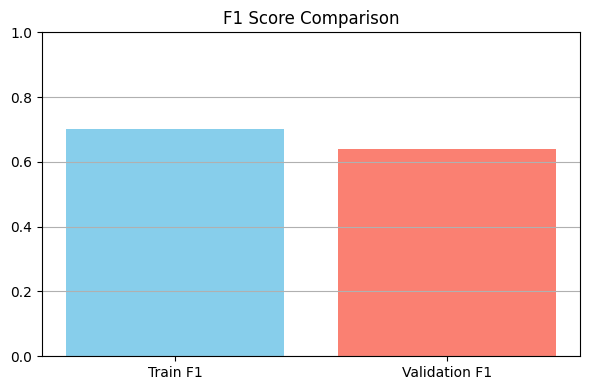

In [13]:
y_pred_train = rf_model_cls.predict(X_train_cls)
y_pred_val = rf_model_cls.predict(X_val_cls)

train_f1 = f1_score(y_train_cls, y_pred_train)
val_f1 = f1_score(y_val_cls, y_pred_val)

plt.figure(figsize=(6,4))
plt.bar(["Train F1", "Validation F1"], [train_f1, val_f1], color=["skyblue", "salmon"])
plt.title("F1 Score Comparison")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

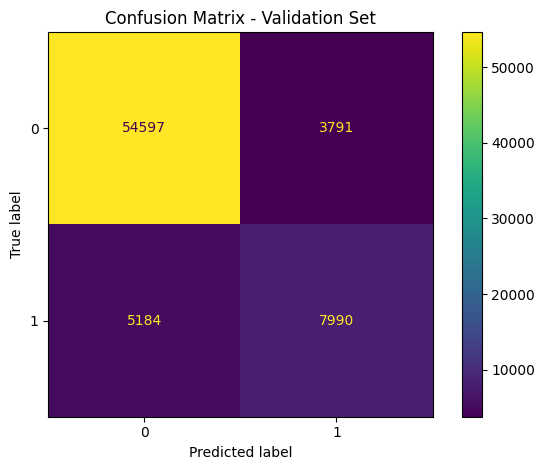

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_val_cls, y_pred_val)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()

In [15]:
# Combine true and predicted labels with predicted probabilities
results_cls_df = pd.DataFrame({
    "true_label": y_val_cls,
    "predicted_label": y_pred_val,
    "probability_0": prob_0,   # Probability for class 0
    "probability_1": prob_1    # Probability for class 1
})

# Save to CSV without index
results_cls_df.to_csv("classification_results.csv", index=False)

# Preview
results_cls_df.head()

,true_label,predicted_label,probability_0,probability_1
0,0,0,1.000000,0.000000
1,0,0,1.000000,0.000000
2,1,0,0.854307,0.145693
3,0,0,0.900491,0.099509
4,0,0,0.994514,0.005486


## 5. Evaluate the model


--- Evaluation on Training Data ---
AUC-ROC:     0.9414
F1-Score:    0.7204
Precision:   0.6306
Recall:      0.8399
Confusion Matrix:
[[243445  29843]
 [  9713  50952]]
Mean G-Mean: 0.8650


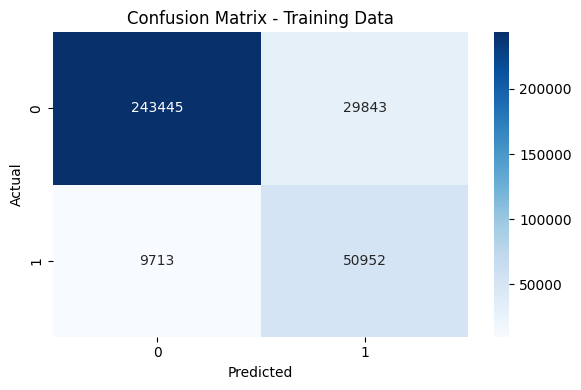


--- Evaluation on Validation Data ---
AUC-ROC:     0.9139
F1-Score:    0.6665
Precision:   0.5820
Recall:      0.7796
Confusion Matrix:
[[51011  7377]
 [ 2903 10271]]
Mean G-Mean: 0.8253


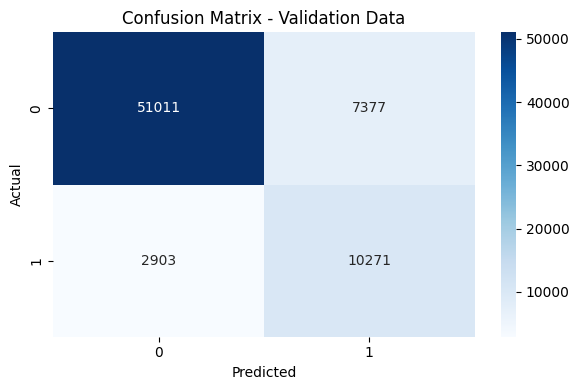


--- Evaluation on Test Data ---
AUC-ROC:     0.9156
F1-Score:    0.6633
Precision:   0.5775
Recall:      0.7790
Confusion Matrix:
[[51284  7362]
 [ 2854 10062]]
Mean G-Mean: 0.8254


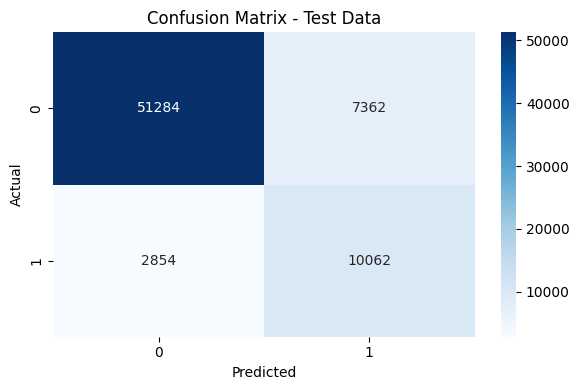

In [16]:
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score,
    recall_score, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_rf_classifier(model, X, y, dataset_name="", threshold=0.3):
    """
    Evaluate a trained rf classifier on given dataset.
    """
    # Predict probabilities and class labels
    prob = model.predict_proba(X)[:, 1]  # Probability of class 1
    preds = (prob > threshold).astype(int)     # Apply threshold

    # Metrics
    auc = roc_auc_score(y, prob)
    f1 = f1_score(y, preds)
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    conf_matrix = confusion_matrix(y, preds)

    # G-Mean
    tn, fp, fn, tp = conf_matrix.ravel()
    tpr = tp / (tp + fn + 1e-6)
    tnr = tn / (tn + fp + 1e-6)
    gmean = np.sqrt(tpr * tnr)

    # Print results
    print(f"\n--- Evaluation on {dataset_name} ---")
    print(f"AUC-ROC:     {auc:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Mean G-Mean: {gmean:.4f}")

    # Confusion matrix plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

evaluate_rf_classifier(rf_model_cls, X_train_cls, y_train_cls, "Training Data")
evaluate_rf_classifier(rf_model_cls, X_val_cls, y_val_cls, "Validation Data")
evaluate_rf_classifier(rf_model_cls, X_test_cls, y_test_cls, "Test Data")


--- Evaluation on Test Data @ 0.3 ---
AUC-ROC:     0.9156
F1-Score:    0.6633
Precision:   0.5775
Recall:      0.7790
Confusion Matrix:
[[51284  7362]
 [ 2854 10062]]
Mean G-Mean: 0.8254


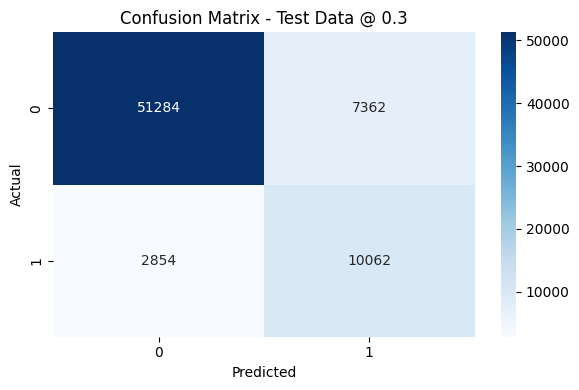


--- Evaluation on Test Data @ 0.1 ---
AUC-ROC:     0.9156
F1-Score:    0.6408
Precision:   0.6779
Recall:      0.6076
Confusion Matrix:
[[54917  3729]
 [ 5068  7848]]
Mean G-Mean: 0.7543


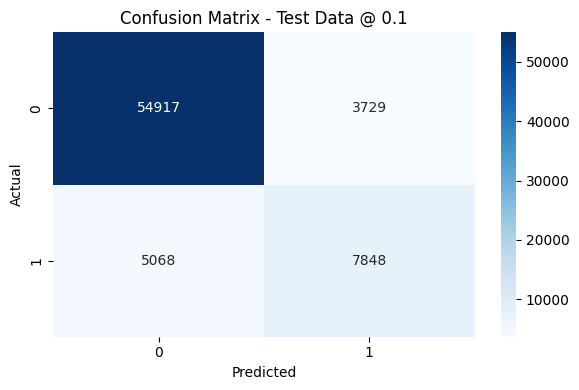


--- Evaluation on Test Data @ 0.5 ---
AUC-ROC:     0.9156
F1-Score:    0.5813
Precision:   0.4225
Recall:      0.9312
Confusion Matrix:
[[42208 16438]
 [  889 12027]]
Mean G-Mean: 0.8186


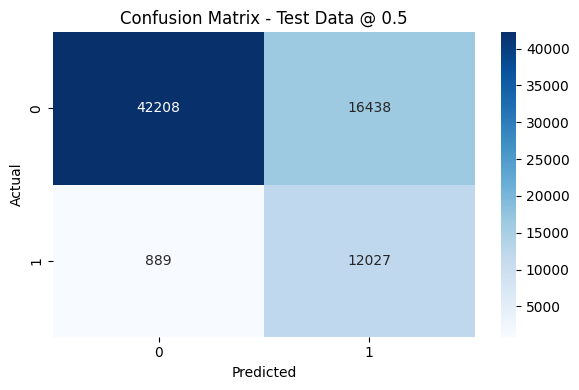

In [17]:
evaluate_rf_classifier(rf_model_cls, X_test_cls, y_test_cls, "Test Data @ 0.3", threshold=0.3)
evaluate_rf_classifier(rf_model_cls, X_test_cls, y_test_cls, "Test Data @ 0.1", threshold=0.5)
evaluate_rf_classifier(rf_model_cls, X_test_cls, y_test_cls, "Test Data @ 0.5", threshold=0.1)

## 6. Save the model

In [18]:
import joblib
import pandas as pd

# Save trained rf model
joblib.dump(rf_model_cls, "rf_cls_model.pkl")

# Save best hyperparameters as CSV
params_df = pd.DataFrame([best_params_cls])
params_df.to_csv("best_params_cls.csv", index=False)

# Save StandardScaler
#joblib.dump(scaler, "scaler.pkl")

## Optional: load the model

In [19]:
'''
import joblib

# Load best hyperparameters from CSV
loaded_params_df = pd.read_csv("best_params_cls.csv")
best_params_cls = loaded_params_df.iloc[0].to_dict()

# Convert integer-like float values to int
best_params_cls['n_neighbors'] = int(best_params_cls['n_neighbors'])
best_params_cls['p'] = int(best_params_cls['p'])
'''

# Load trained rf model
rf_model_cls = joblib.load("/content/drive/MyDrive/ERP/Random Forest/rf_cls_model.pkl")

# Load scaler
#scaler = joblib.load("scaler.pkl")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
